# 14. Efficiency

## План

1. Factorization: Low-Rank Adaptation (LoRA)
2. Distillation: (Hinton KD, Zagoruyko AT)
3. Pruning: Lottery Ticket Hypothesis
4. Quantization: GPT-Q

## 0. Ключ wandb

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_API_KEY"] = "your_key"
import wandb

import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=120,
    target_version=black.TargetVersion.PY311,
)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

## 1.Factorization: Low-Rank Adaptation (LoRA)

В этом блоке посмотрим, как использовать [LoRA](https://arxiv.org/abs/2106.09685) из 🤗 PEFT для файнтюнинга модели SegFormer для семантической сегментации, используя только небольшую долю исходных обучаемых параметров модели. 

LoRA добавляет низкоранговые "матрицы обновления" к определенным блокам базовой модели (в данном случае к блокам внимания) и обучает только эти матрицы во время файнтюнинга.

Во время инференса эти матрицы обновления _сливаются_ с исходными параметрами модели. Более подробно можно почитать в [оригинальной статье LoRA](https://arxiv.org/abs/2106.09685). 

<div>
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png" width=70%/>
</div>

### MVP алгоритма

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
from typing import Optional, List


class LoRALayer:
    def __init__(
        self,
        r: int,
        lora_alpha: int,
        lora_dropout: float,
        merge_weights: bool,
    ):
        self.r = r
        self.lora_alpha = lora_alpha
        # Optional dropout
        if lora_dropout > 0.0:
            self.lora_dropout = nn.Dropout(p=lora_dropout)
        else:
            self.lora_dropout = lambda x: x
        # Mark the weight as unmerged
        self.merged = False
        self.merge_weights = merge_weights


class Linear(nn.Linear, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self,
        in_features: int,
        out_features: int,
        r: int = 0,
        lora_alpha: int = 1,
        lora_dropout: float = 0.0,
        fan_in_fan_out: bool = False,  # Set this to True if the layer to replace stores weight like (fan_in, fan_out)
        merge_weights: bool = True,
        **kwargs,
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout, merge_weights=merge_weights)

        self.fan_in_fan_out = fan_in_fan_out
        # Actual trainable parameters
        if r > 0:
            self.lora_A = nn.Parameter(self.weight.new_zeros((r, in_features)))
            self.lora_B = nn.Parameter(self.weight.new_zeros((out_features, r)))
            self.scaling = self.lora_alpha / self.r
            # Freezing the pre-trained weight matrix
            self.weight.requires_grad = False
        self.reset_parameters()
        if fan_in_fan_out:
            self.weight.data = self.weight.data.transpose(0, 1)

    def reset_parameters(self):
        nn.Linear.reset_parameters(self)
        if hasattr(self, "lora_A"):
            # initialize A the same way as the default for nn.Linear and B to zero
            # this is different than what is described in the paper but should not affect performance
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)

    def train(self, mode: bool = True):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w

        nn.Linear.train(self, mode)
        if mode:
            if self.merge_weights and self.merged:
                # Make sure that the weights are not merged
                if self.r > 0:
                    self.weight.data -= T(self.lora_B @ self.lora_A) * self.scaling
                self.merged = False
        else:
            if self.merge_weights and not self.merged:
                # Merge the weights and mark it
                if self.r > 0:
                    self.weight.data += T(self.lora_B @ self.lora_A) * self.scaling
                self.merged = True

    def forward(self, x: torch.Tensor):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w

        ## YOUR CODE ##
        result = F.linear(x, T(self.weight), bias=self.bias)
        if self.r > 0 and not self.merged:
            result += (self.lora_dropout(x) @ self.lora_A.transpose(0, 1) @ self.lora_B.transpose(0, 1)) * self.scaling
        return result

In [3]:
torch.cuda.device_count()

1

In [4]:
# !pip install transformers accelerate evaluate datasets git+https://github.com/huggingface/peft -q

Можно залить обученную модель прямо в huggingface.

In [5]:
from huggingface_hub import notebook_login

notebook_login()

### Load a dataset

We're only loading the first 150 instances from the training set of the [SceneParse150 dataset](https://huggingface.co/datasets/scene_parse_150) to keep this example runtime short. 

In [6]:
from datasets import load_dataset

ds = load_dataset("scene_parse_150", split="train[:2000]")

### Prepare train and test splits

In [7]:
ds = ds.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

### Prepare label mappers

We create two dictionaries:

* `label2id`: maps the semantic classes of the dataset to integer ids.
* `id2label`: `label2id` reversed. 

In [8]:
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

/home/jovyan/kurkin/miniconda3/envs/torch/lib/python3.11/site-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


### Prepare datasets for training and evaluation

In [9]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, do_reduce_labels=True)

2023-12-15 17:08:26.657836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/jovyan/kurkin/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [10]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

In [11]:
import matplotlib.pyplot as plt

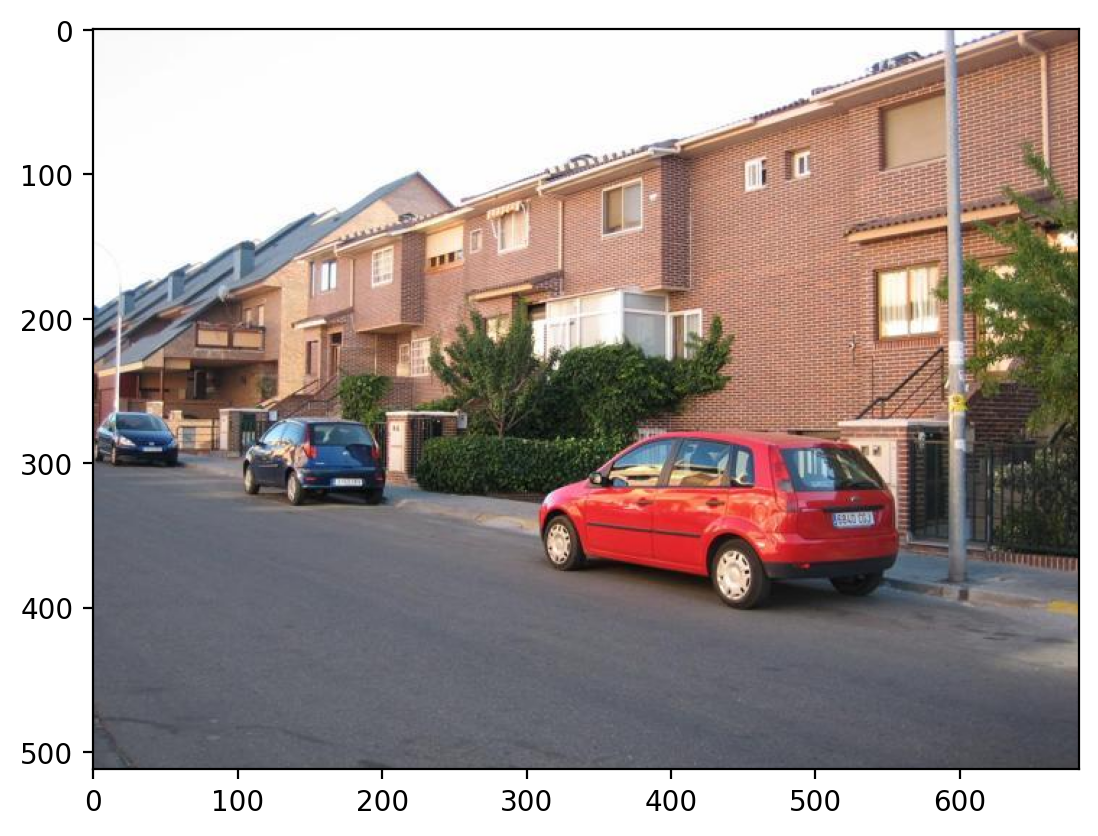

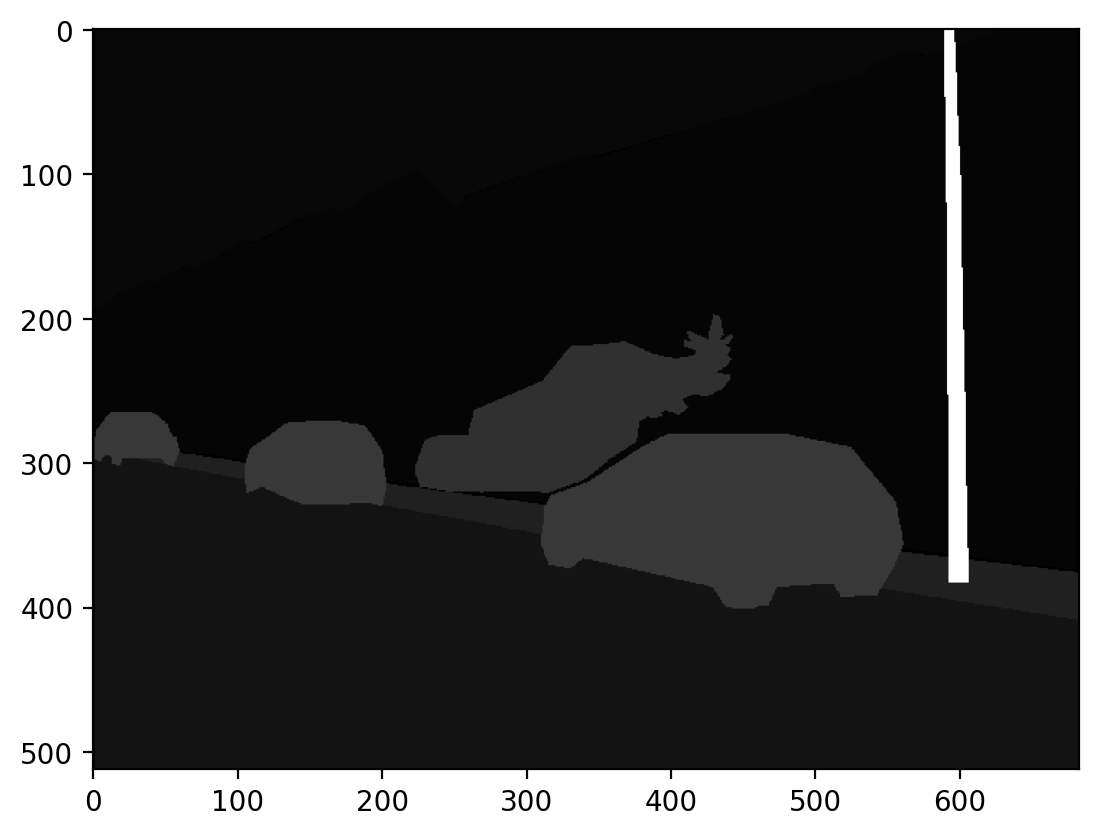

In [12]:
plt.imshow(ds["train"][1]["image"])
plt.show()
plt.imshow(ds["train"][1]["annotation"], cmap="gray")

In [13]:
from PIL import Image
import numpy as np


def handle_grayscale_image(image):
    np_image = np.array(image)
    if np_image.ndim == 2:
        tiled_image = np.tile(np.expand_dims(np_image, -1), 3)
        return Image.fromarray(tiled_image)
    else:
        return Image.fromarray(np_image)


def train_transforms(example_batch):
    images = [jitter(handle_grayscale_image(x)) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [handle_grayscale_image(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs

In [14]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

### Evaluation function

Including a metric during training is often helpful for evaluating your model’s performance. You can quickly load a evaluation method with the [🤗 Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [mean Intersection over Union (IoU)](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [15]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")


def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=image_processor.do_reduce_labels,
        )

        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
[2023-12-15 17:08:32,147] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


### Load a base model

For this example, we use the [SegFormer B0 variant](https://huggingface.co/nvidia/mit-b0). 

In [16]:
def get_trainable_parameters(model):
    """
    Counts the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    return f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"

We pass the `label2id` and `id2label` dictionaries to let the `AutoModelForSemanticSegmentation` class know that we're interested in a custom base model where the decoder head should be randomly initialized w.r.t our custom dataset. Note, however, that the rest of the model parameters are pre-trained and will be fine-tuned in a regular transfer learning setup.

We also notice that the 100% parameters in the `model` are trainable. 

In [17]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(
    checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)
get_trainable_parameters(model)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'trainable params: 3752694 || all params: 3752694 || trainable%: 100.00'

### Wrap `model` as a `PeftModel` for LoRA training

This involves two steps:

* Defining a config with `LoraConfig`
* Wrapping the original `model` with `get_peft_model()` with the config defined in the step above. 

In [18]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, config)
get_trainable_parameters(lora_model)

'trainable params: 999724 || all params: 4317068 || trainable%: 23.16'

 Let's unpack what's going on here. 

In order for LoRA to take effect, we need to specify the target modules to `LoraConfig` so that `PeftModel` knows which modules inside our model needs to be amended with LoRA matrices. In this case, we're only interested in targetting the query and value matrices of the attention blocks of the base model. Since the parameters corresponding to these matrices are "named" with `query` and `value` respectively, we specify them accordingly in the `target_modules` argument of `LoraConfig`. 

We also specify `modules_to_save`. After we wrap our base model `model` with `PeftModel` along with the `config`, we get a new model where only the LoRA parameters are trainable (so-called "update matrices") while the pre-trained parameters are kept frozen. These include the parameters of the randomly initialized classifier parameters too. This is NOT we want when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify `modules_to_save`. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like `save_pretrained()` and `push_to_hub()`.  

Regarding the other parameters:

* `r`: The dimension used by the LoRA update matrices.
* `alpha`: Scaling factor.
* `bias`: Specifying if the `bias` parameters should be trained. `lora_only` denotes only the LoRA `bias` parameters will be trained. 

`r` and `alpha` together control the total number of final trainable parameters when using LoRA giving us the flexbility to balance a trade-off between end performance and compute efficiency.


We can also how many parameters we're actually training. Since we're interested in performing **parameter-efficient fine-tuning**, we should expect to notice a less number of trainable parameters from the `lora_model` in comparison to the original `model` which is indeed the case here. 

For sanity, let's also manually verify the modules that are actually trainable in `lora_model`. 

In [19]:
grad_params = []

for name, param in lora_model.named_parameters():
    if param.requires_grad:
        grad_params.append((name, param.shape))

In [20]:
print(*grad_params, sep="\n")

('base_model.model.segformer.encoder.block.0.0.attention.self.query.bias', torch.Size([32]))
('base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_A.default.weight', torch.Size([32, 32]))
('base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_B.default.weight', torch.Size([32, 32]))
('base_model.model.segformer.encoder.block.0.0.attention.self.value.bias', torch.Size([32]))
('base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_A.default.weight', torch.Size([32, 32]))
('base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_B.default.weight', torch.Size([32, 32]))
('base_model.model.segformer.encoder.block.0.1.attention.self.query.bias', torch.Size([32]))
('base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_A.default.weight', torch.Size([32, 32]))
('base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_B.default.weight', torch.Size([32, 32]))
('base_model.model.segformer.encoder.

We can confirm that only the LoRA parameters appended to the attention blocks and the `decode_head` parameters are trainable.

### Train!

This is a two-step process: 

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/trainer#transformers.TrainingArguments). It is important you don’t remove unused columns because this’ll drop the image column. Without the image column, you can’t create `pixel_values`. Set `remove_unused_columns=False` to prevent this behavior! The only other required parameter is output_dir which specifies where to save your model. At the end of each epoch, the `Trainer` will evaluate the IoU metric and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call `train()` to finetune your model.


**Note** that This example is meant to walk you through the workflow when using PEFT for semantic segmentation. We didn't perform extensive hyperparameter tuning to achieve optimal results. 

In [21]:
import gc


model_name = checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-scene-parse-{len(ds['train'])}-lora",
    learning_rate=5e-4,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    dataloader_num_workers=8,
    per_device_eval_batch_size=4,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=100,
    warmup_ratio=0.05,
    save_strategy="epoch",
    logging_steps=5,
    bf16=True,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    report_to="wandb",
    seed=1337,
    run_name="b0-lora-baseline",
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

wandb: Currently logged in as: dondo_sss. Use `wandb login --relogin` to force relogin


/home/jovyan/kurkin/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Wall,Accuracy Building,Accuracy Sky,Accuracy Floor,Accuracy Tree,Accuracy Ceiling,Accuracy Road,Accuracy Bed,Accuracy Windowpane,Accuracy Grass,Accuracy Cabinet,Accuracy Sidewalk,Accuracy Person,Accuracy Earth,Accuracy Door,Accuracy Table,Accuracy Mountain,Accuracy Plant,Accuracy Curtain,Accuracy Chair,Accuracy Car,Accuracy Water,Accuracy Painting,Accuracy Sofa,Accuracy Shelf,Accuracy House,Accuracy Sea,Accuracy Mirror,Accuracy Rug,Accuracy Field,Accuracy Armchair,Accuracy Seat,Accuracy Fence,Accuracy Desk,Accuracy Rock,Accuracy Wardrobe,Accuracy Lamp,Accuracy Bathtub,Accuracy Railing,Accuracy Cushion,Accuracy Base,Accuracy Box,Accuracy Column,Accuracy Signboard,Accuracy Chest of drawers,Accuracy Counter,Accuracy Sand,Accuracy Sink,Accuracy Skyscraper,Accuracy Fireplace,Accuracy Refrigerator,Accuracy Grandstand,Accuracy Path,Accuracy Stairs,Accuracy Runway,Accuracy Case,Accuracy Pool table,Accuracy Pillow,Accuracy Screen door,Accuracy Stairway,Accuracy River,Accuracy Bridge,Accuracy Bookcase,Accuracy Blind,Accuracy Coffee table,Accuracy Toilet,Accuracy Flower,Accuracy Book,Accuracy Hill,Accuracy Bench,Accuracy Countertop,Accuracy Stove,Accuracy Palm,Accuracy Kitchen island,Accuracy Computer,Accuracy Swivel chair,Accuracy Boat,Accuracy Bar,Accuracy Arcade machine,Accuracy Hovel,Accuracy Bus,Accuracy Towel,Accuracy Light,Accuracy Truck,Accuracy Tower,Accuracy Chandelier,Accuracy Awning,Accuracy Streetlight,Accuracy Booth,Accuracy Television receiver,Accuracy Airplane,Accuracy Dirt track,Accuracy Apparel,Accuracy Pole,Accuracy Land,Accuracy Bannister,Accuracy Escalator,Accuracy Ottoman,Accuracy Bottle,Accuracy Buffet,Accuracy Poster,Accuracy Stage,Accuracy Van,Accuracy Ship,Accuracy Fountain,Accuracy Conveyer belt,Accuracy Canopy,Accuracy Washer,Accuracy Plaything,Accuracy Swimming pool,Accuracy Stool,Accuracy Barrel,Accuracy Basket,Accuracy Waterfall,Accuracy Tent,Accuracy Bag,Accuracy Minibike,Accuracy Cradle,Accuracy Oven,Accuracy Ball,Accuracy Food,Accuracy Step,Accuracy Tank,Accuracy Trade name,Accuracy Microwave,Accuracy Pot,Accuracy Animal,Accuracy Bicycle,Accuracy Lake,Accuracy Dishwasher,Accuracy Screen,Accuracy Blanket,Accuracy Sculpture,Accuracy Hood,Accuracy Sconce,Accuracy Vase,Accuracy Traffic light,Accuracy Tray,Accuracy Ashcan,Accuracy Fan,Accuracy Pier,Accuracy Crt screen,Accuracy Plate,Accuracy Monitor,Accuracy Bulletin board,Accuracy Shower,Accuracy Radiator,Accuracy Glass,Accuracy Clock,Accuracy Flag,Iou Wall,Iou Building,Iou Sky,Iou Floor,Iou Tree,Iou Ceiling,Iou Road,Iou Bed,Iou Windowpane,Iou Grass,Iou Cabinet,Iou Sidewalk,Iou Person,Iou Earth,Iou Door,Iou Table,Iou Mountain,Iou Plant,Iou Curtain,Iou Chair,Iou Car,Iou Water,Iou Painting,Iou Sofa,Iou Shelf,Iou House,Iou Sea,Iou Mirror,Iou Rug,Iou Field,Iou Armchair,Iou Seat,Iou Fence,Iou Desk,Iou Rock,Iou Wardrobe,Iou Lamp,Iou Bathtub,Iou Railing,Iou Cushion,Iou Base,Iou Box,Iou Column,Iou Signboard,Iou Chest of drawers,Iou Counter,Iou Sand,Iou Sink,Iou Skyscraper,Iou Fireplace,Iou Refrigerator,Iou Grandstand,Iou Path,Iou Stairs,Iou Runway,Iou Case,Iou Pool table,Iou Pillow,Iou Screen door,Iou Stairway,Iou River,Iou Bridge,Iou Bookcase,Iou Blind,Iou Coffee table,Iou Toilet,Iou Flower,Iou Book,Iou Hill,Iou Bench,Iou Countertop,Iou Stove,Iou Palm,Iou Kitchen island,Iou Computer,Iou Swivel chair,Iou Boat,Iou Bar,Iou Arcade machine,Iou Hovel,Iou Bus,Iou Towel,Iou Light,Iou Truck,Iou Tower,Iou Chandelier,Iou Awning,Iou Streetlight,Iou Booth,Iou Television receiver,Iou Airplane,Iou Dirt track,Iou Apparel,Iou Pole,Iou Land,Iou Bannister,Iou Escalator,Iou Ottoman,Iou Bottle,Iou Buffet,Iou Poster,Iou Stage,Iou Van,Iou Ship,Iou Fountain,Iou Conveyer belt,Iou Canopy,Iou Washer,Iou Plaything,Iou Swimming pool,Iou Stool,Iou Barrel,Iou Basket,Iou Waterfall,Iou Tent,Iou Bag,Iou Minibike,Iou Cradle,Iou Oven,Iou Ball,Iou Food,Iou Step,Iou Tank,Iou Trade name,Iou Microwave,Iou Pot,Iou Animal,I

/home/jovyan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/jovyan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/home/jovyan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/jovyan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeW

TrainOutput(global_step=1125, training_loss=1.8271660012139215, metrics={'train_runtime': 1908.798, 'train_samples_per_second': 4.715, 'train_steps_per_second': 0.589, 'total_flos': 1.83334342754304e+17, 'train_loss': 1.8271660012139215, 'epoch': 5.0})

In [23]:
wandb.finish()

eval/accuracy_animal,▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_apparel,▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_arcade machine,▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_armchair,▁▁▁▁▁█▁▁▁▁▁
eval/accuracy_ashcan,▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_awning,▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_bag,▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_ball,▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_bannister,▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_bar,▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_barrel,▁▁▁▁▁▁▁▁▁▁▁


### Saving the model and inference 

Here we use the `save_pretrained()` method of the `lora_model` to save the *LoRA-only parameters* locally. However, you can also use thr `push_to_hub()` method to upload these parameters directly to the Hugging Face Hub (as shown [here](https://colab.research.google.com/github/huggingface/peft/blob/main/examples/image_classification/image_classification_peft_lora.ipynb)). 

In [27]:
model_id = "segformer-scene-parse-150-lora"
lora_model.save_pretrained(model_id)

We can see that the LoRA-only parameters are just **2.2 MB in size**! This greatly improves the portability when using very large models. 

In [28]:
!ls -lh {model_id}

total 2.3M
-rw-r--r-- 1 jovyan jovyan  101 Dec 15 17:48 README.md
-rw-r--r-- 1 jovyan jovyan  584 Dec 15 17:48 adapter_config.json
-rw-r--r-- 1 jovyan jovyan 2.2M Dec 15 17:48 adapter_model.bin


Let's now prepare our `inference_model` and run an inference. 

In [30]:
from peft import PeftConfig, PeftModel

config = PeftConfig.from_pretrained(model_id)
model = AutoModelForSemanticSegmentation.from_pretrained(
    checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)
# Load the Lora model
inference_model = PeftModel.from_pretrained(model, model_id)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetch an image.

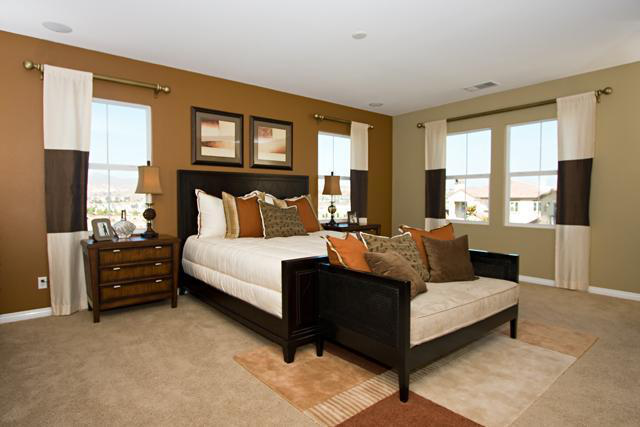

In [31]:
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/semantic-seg-image.png"
image = Image.open(requests.get(url, stream=True).raw)
image

Preprocess the image.

In [32]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 512, 512])


Run an inference. 

In [33]:
with torch.no_grad():
    outputs = inference_model(pixel_values=encoding.pixel_values)
    logits = outputs.logits

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

Visualize the results.

We need a color palette to visualize the results. Here, we use [one provided by the TensorFlow Model Garden repository](https://github.com/tensorflow/models/blob/3f1ca33afe3c1631b733ea7e40c294273b9e406d/research/deeplab/utils/get_dataset_colormap.py#L51).

In [34]:
def ade_palette():
    """Creates a label colormap used in ADE20K segmentation benchmark.
    Returns:
    A colormap for visualizing segmentation results.
    """
    return np.asarray(
        [
            [0, 0, 0],
            [120, 120, 120],
            [180, 120, 120],
            [6, 230, 230],
            [80, 50, 50],
            [4, 200, 3],
            [120, 120, 80],
            [140, 140, 140],
            [204, 5, 255],
            [230, 230, 230],
            [4, 250, 7],
            [224, 5, 255],
            [235, 255, 7],
            [150, 5, 61],
            [120, 120, 70],
            [8, 255, 51],
            [255, 6, 82],
            [143, 255, 140],
            [204, 255, 4],
            [255, 51, 7],
            [204, 70, 3],
            [0, 102, 200],
            [61, 230, 250],
            [255, 6, 51],
            [11, 102, 255],
            [255, 7, 71],
            [255, 9, 224],
            [9, 7, 230],
            [220, 220, 220],
            [255, 9, 92],
            [112, 9, 255],
            [8, 255, 214],
            [7, 255, 224],
            [255, 184, 6],
            [10, 255, 71],
            [255, 41, 10],
            [7, 255, 255],
            [224, 255, 8],
            [102, 8, 255],
            [255, 61, 6],
            [255, 194, 7],
            [255, 122, 8],
            [0, 255, 20],
            [255, 8, 41],
            [255, 5, 153],
            [6, 51, 255],
            [235, 12, 255],
            [160, 150, 20],
            [0, 163, 255],
            [140, 140, 140],
            [250, 10, 15],
            [20, 255, 0],
            [31, 255, 0],
            [255, 31, 0],
            [255, 224, 0],
            [153, 255, 0],
            [0, 0, 255],
            [255, 71, 0],
            [0, 235, 255],
            [0, 173, 255],
            [31, 0, 255],
            [11, 200, 200],
            [255, 82, 0],
            [0, 255, 245],
            [0, 61, 255],
            [0, 255, 112],
            [0, 255, 133],
            [255, 0, 0],
            [255, 163, 0],
            [255, 102, 0],
            [194, 255, 0],
            [0, 143, 255],
            [51, 255, 0],
            [0, 82, 255],
            [0, 255, 41],
            [0, 255, 173],
            [10, 0, 255],
            [173, 255, 0],
            [0, 255, 153],
            [255, 92, 0],
            [255, 0, 255],
            [255, 0, 245],
            [255, 0, 102],
            [255, 173, 0],
            [255, 0, 20],
            [255, 184, 184],
            [0, 31, 255],
            [0, 255, 61],
            [0, 71, 255],
            [255, 0, 204],
            [0, 255, 194],
            [0, 255, 82],
            [0, 10, 255],
            [0, 112, 255],
            [51, 0, 255],
            [0, 194, 255],
            [0, 122, 255],
            [0, 255, 163],
            [255, 153, 0],
            [0, 255, 10],
            [255, 112, 0],
            [143, 255, 0],
            [82, 0, 255],
            [163, 255, 0],
            [255, 235, 0],
            [8, 184, 170],
            [133, 0, 255],
            [0, 255, 92],
            [184, 0, 255],
            [255, 0, 31],
            [0, 184, 255],
            [0, 214, 255],
            [255, 0, 112],
            [92, 255, 0],
            [0, 224, 255],
            [112, 224, 255],
            [70, 184, 160],
            [163, 0, 255],
            [153, 0, 255],
            [71, 255, 0],
            [255, 0, 163],
            [255, 204, 0],
            [255, 0, 143],
            [0, 255, 235],
            [133, 255, 0],
            [255, 0, 235],
            [245, 0, 255],
            [255, 0, 122],
            [255, 245, 0],
            [10, 190, 212],
            [214, 255, 0],
            [0, 204, 255],
            [20, 0, 255],
            [255, 255, 0],
            [0, 153, 255],
            [0, 41, 255],
            [0, 255, 204],
            [41, 0, 255],
            [41, 255, 0],
            [173, 0, 255],
            [0, 245, 255],
            [71, 0, 255],
            [122, 0, 255],
            [0, 255, 184],
            [0, 92, 255],
            [184, 255, 0],
            [0, 133, 255],
            [255, 214, 0],
            [25, 194, 194],
            [102, 255, 0],
            [92, 0, 255],
        ]
    )

In [46]:
import matplotlib.pyplot as plt

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())

for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR
color_idx = np.unique(pred_seg)

labels = [id2label[i] for i in color_idx]

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)


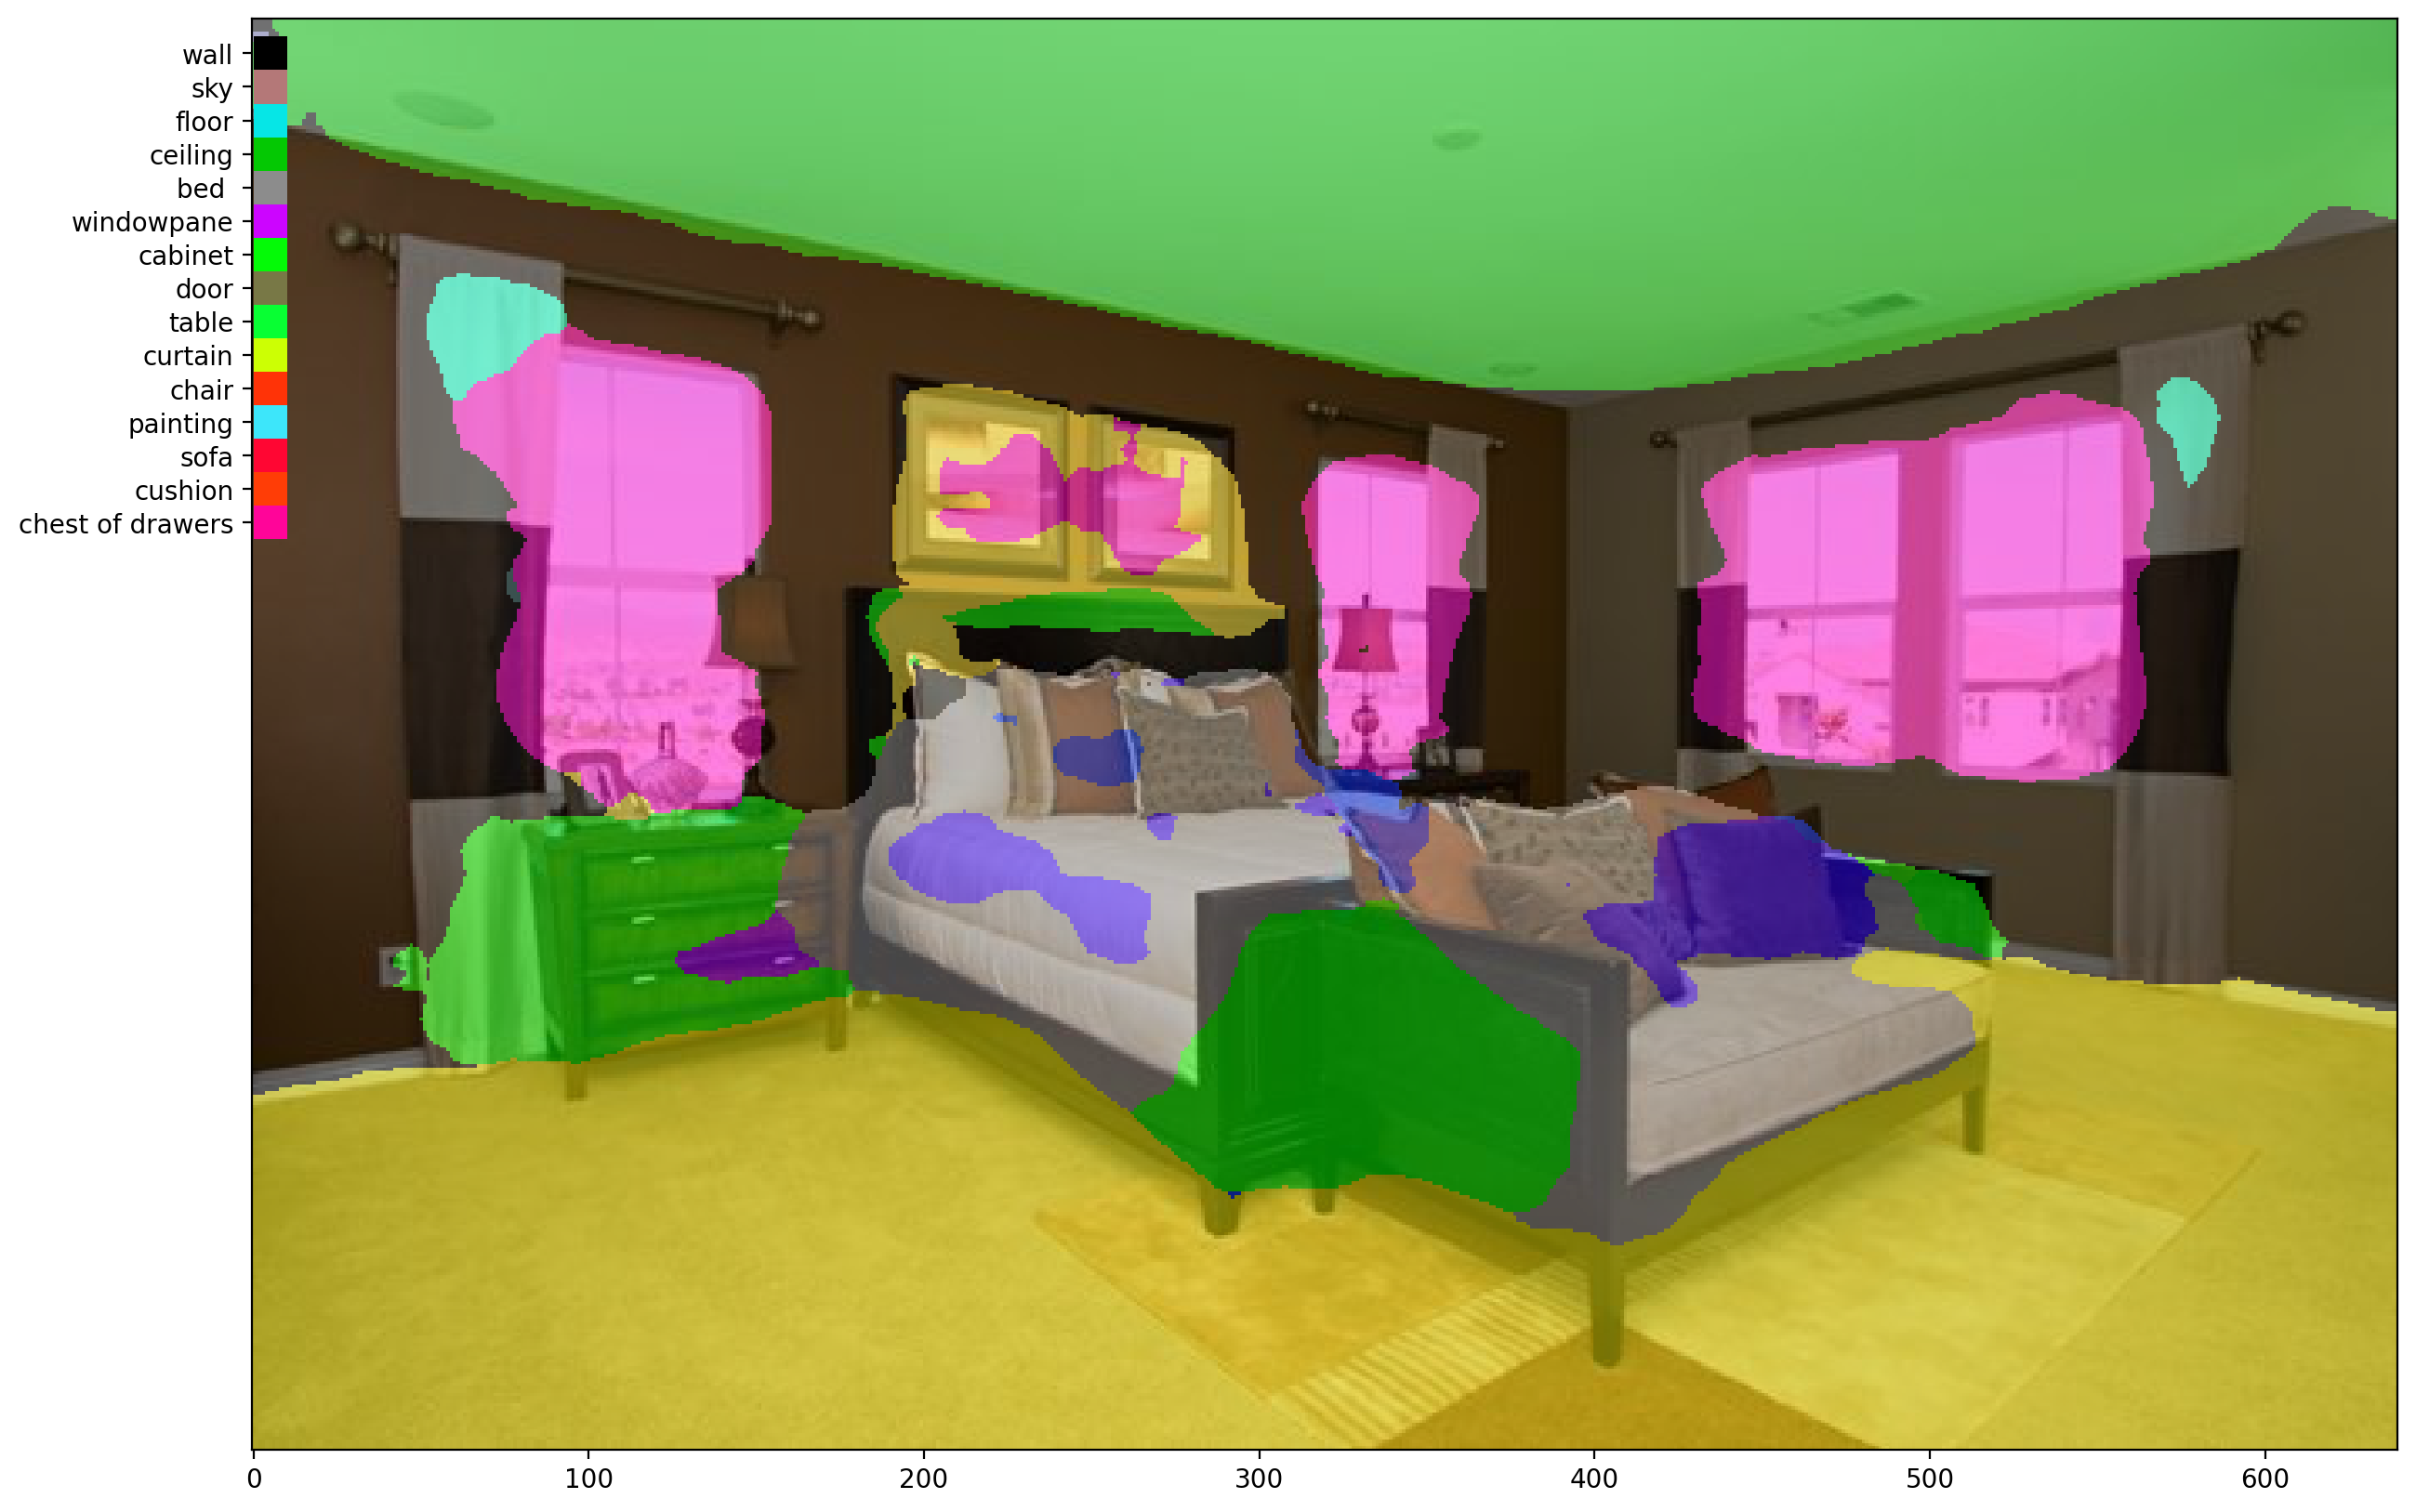

In [55]:
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.barh(
    y=np.arange(len(color_idx)) * 10 + 10,
    height=np.ones(len(color_idx)) * 10,
    width=10,
    tick_label=labels,
    align="center",
    color=palette[color_idx] / 255.0,
)
plt.show()

The results are definitely not as expected and as mentioned above, this example is not meant to provide a state-of-the-art model. It exists to familiarize you with the end-to-end workflow. 

On the other hand, if you perform full fine-tuning on the same setup (same model variant, same dataset, same training schedule, etc.), the results would not have been any different. This is a crucial aspect of parameter-efficient fine-tuning -- to be able to match up to the results of the full fine-tuning but with a fraction of total trainable parameters. 

Here are some things that you can try to get better results:

* Increase the number of training samples. 
* Try a larger SegFormer model variant (know about the available model variants [here](https://huggingface.co/models?search=segformer)). 
* Try different values for the arguments available in `LoraConfig`. 
* Tune the learning rate and batch size. 

## 2. Distillation: (Hinton KD, Zagoruyko AT)
<div>
<img src="resources/kd.png" width=70%/>
</div>

<div>
<img src="resources/at.png" width=70%/>
</div>

In [3]:
import numpy as np
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchdistill.core.forward_hook import ForwardHookManager

import matplotlib.pyplot as plt

%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args = {}
kwargs = {}
args["batch_size"] = 1000
args["test_batch_size"] = 1000
args["epochs"] = 5  # The number of Epochs is the number of times you go through the full dataset.
args["lr"] = 0.1  # Learning rate is how fast it will decend.
args[
    "momentum"
] = 0.5  # SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args["seed"] = 1  # random seed
args["log_interval"] = 60
args["cuda"] = True

In [4]:
# fix random seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

g = torch.Generator()
g.manual_seed(0)


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
# load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
    ),
    batch_size=args["batch_size"],
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=False,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
    ),
    batch_size=args["batch_size"],
    shuffle=True,
)

In [6]:
def train(model, epoch, optimizer, args=args):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.cross_entropy(output, target)
        # dloss/dx for every Variable
        loss.backward()
        # to do a one-step update on our parameter.
        optimizer.step()
        # Print out the loss periodically.
        if batch_idx % args["log_interval"] == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model, args=args):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)
        )
    )

    return 100.0 * correct / len(test_loader.dataset)

### Train Teacher model on MNIST

In [17]:
class TeacherNetClass(nn.Module):
    # This defines the structure of the NN.
    def __init__(self):
        super(TeacherNetClass, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()  # Dropout
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(800, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Fully Connected Layer/Activation
        x = F.relu(self.fc1(self.flatten(x)))
        x = F.dropout(x, training=self.training)
        # Fully Connected Layer/Activation
        x = self.fc2(x)
        # Softmax gets probabilities.
        return x

In [18]:
teacher = TeacherNetClass()

In [20]:
teacher = TeacherNetClass()
teacher.to(device)

optimizer = optim.SGD(teacher.parameters(), lr=args["lr"], momentum=args["momentum"])

for epoch in range(args["epochs"]):
    train(teacher, epoch, optimizer)
    test(teacher)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320510

Test set: Average loss: 0.0003, Accuracy: 9207/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.557310

Test set: Average loss: 0.0002, Accuracy: 9534/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.343708

Test set: Average loss: 0.0001, Accuracy: 9650/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.256466

Test set: Average loss: 0.0001, Accuracy: 9714/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.253403

Test set: Average loss: 0.0001, Accuracy: 9754/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.198291

Test set: Average loss: 0.0001, Accuracy: 9773/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.220403

Test set: Average loss: 0.0001, Accuracy: 9778/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.183960

Test set: Average loss: 0.0001, Accuracy: 9806/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.135902

Test set: Average loss: 0.0001, Accuracy: 9809/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.165327


### 1 Train Student Model without KD

We define Student's architecture same as Teacher's but with smaller number width in some layers

In [28]:
class StudentNetClass(nn.Module):
    # This defines the structure of the NN.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()  # Dropout
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Fully Connected Layer/Activation
        x = F.relu(self.fc1(self.flatten(x)))
        x = F.dropout(x, training=self.training)
        # Fully Connected Layer/Activation
        x = self.fc2(x)
        # Softmax gets probabilities.
        return x

In [29]:
student = StudentNetClass()
student.to(device)
acc_list_wo_kd = []

optimizer = optim.SGD(student.parameters(), lr=args["lr"], momentum=args["momentum"])

for epoch in range(args["epochs"]):
    train(student, epoch, optimizer)
    acc_list_wo_kd.append(test(student))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.330376

Test set: Average loss: 0.0003, Accuracy: 9135/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.618252

Test set: Average loss: 0.0002, Accuracy: 9409/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.417053

Test set: Average loss: 0.0001, Accuracy: 9562/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.307956

Test set: Average loss: 0.0001, Accuracy: 9643/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.286812

Test set: Average loss: 0.0001, Accuracy: 9681/10000 (97%)



### Train Student with Hinton KD

$$\mathcal{L}=(1-\alpha) \mathcal{L}_{c e}\left(z_{s}, y\right)+\alpha \mathcal{L}_{c e}\left(z_{s}, z_{t}\right)$$

In [47]:
class KDLoss(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    https://arxiv.org/abs/1503.02531
    """

    def __init__(self, T=1, alpha=0.1):
        super().__init__()
        self.T = T
        self.alpha = alpha

    def forward(self, student_pred, teacher_pred, y):
        """
        Loss function for student network: Loss = alpha * (distillation loss with soft-target) + (1 - alpha) * (cross-entropy loss with true label)
        Return: loss
        """
        if self.alpha > 0:
            loss = F.kl_div(
                F.log_softmax(student_pred / self.T, dim=1),
                F.softmax(teacher_pred / self.T, dim=1),
                reduction="batchmean",
            ) * (self.T**2) * self.alpha + F.cross_entropy(student_pred, y) * (1 - self.alpha)
        else:
            loss = F.cross_entropy(student_pred, y)
        return loss

In [73]:
def train_kd(
    teacher,
    student,
    epoch,
    optimizer,
    kd_loss,
    alpha=0.1,
    args=args,
):
    teacher.to(device)
    teacher.eval()
    student.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = student(data)

        with torch.no_grad():
            output_t = teacher(data)

        # Calculate KD Loss
        loss = kd_loss(output, output_t, target)
        # dloss/dx for every Variable
        loss.backward()
        # to do a one-step update on our parameter.
        optimizer.step()
        # Print out the loss periodically.
        if batch_idx % args["log_interval"] == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

In [81]:
alphas = [0, 0.02, 0.07, 0.2, 0.4, 1.0]

exp_dict = {}

for alpha in alphas:
    print(f"__________(alpha = {alpha})__________")
    acc_list = []
    student_hint = StudentNetClass()
    student_hint.to(device)

    # Create forward hooks for outputs of conv1 and conv2 for teacher and student
    kd_loss = KDLoss(T=5, alpha=alpha)

    optimizer = optim.SGD(student_hint.parameters(), lr=args["lr"], momentum=args["momentum"])

    for epoch in range(args["epochs"]):
        train_kd(teacher, student_hint, epoch, optimizer, kd_loss)
        acc_list.append(test(student_hint))

    exp_dict[alpha] = acc_list

__________(alpha = 0)__________
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311936

Test set: Average loss: 0.0003, Accuracy: 9093/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.587871

Test set: Average loss: 0.0002, Accuracy: 9411/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.469921

Test set: Average loss: 0.0002, Accuracy: 9509/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.362676

Test set: Average loss: 0.0001, Accuracy: 9605/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.315680

Test set: Average loss: 0.0001, Accuracy: 9623/10000 (96%)

__________(alpha = 0.02)__________
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.693729

Test set: Average loss: 0.0003, Accuracy: 9105/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.836981

Test set: Average loss: 0.0002, Accuracy: 9407/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.526373

Test set: Average loss: 0.0001, Accuracy: 9558/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.500279

Test set: Average loss: 0.0001, Accurac

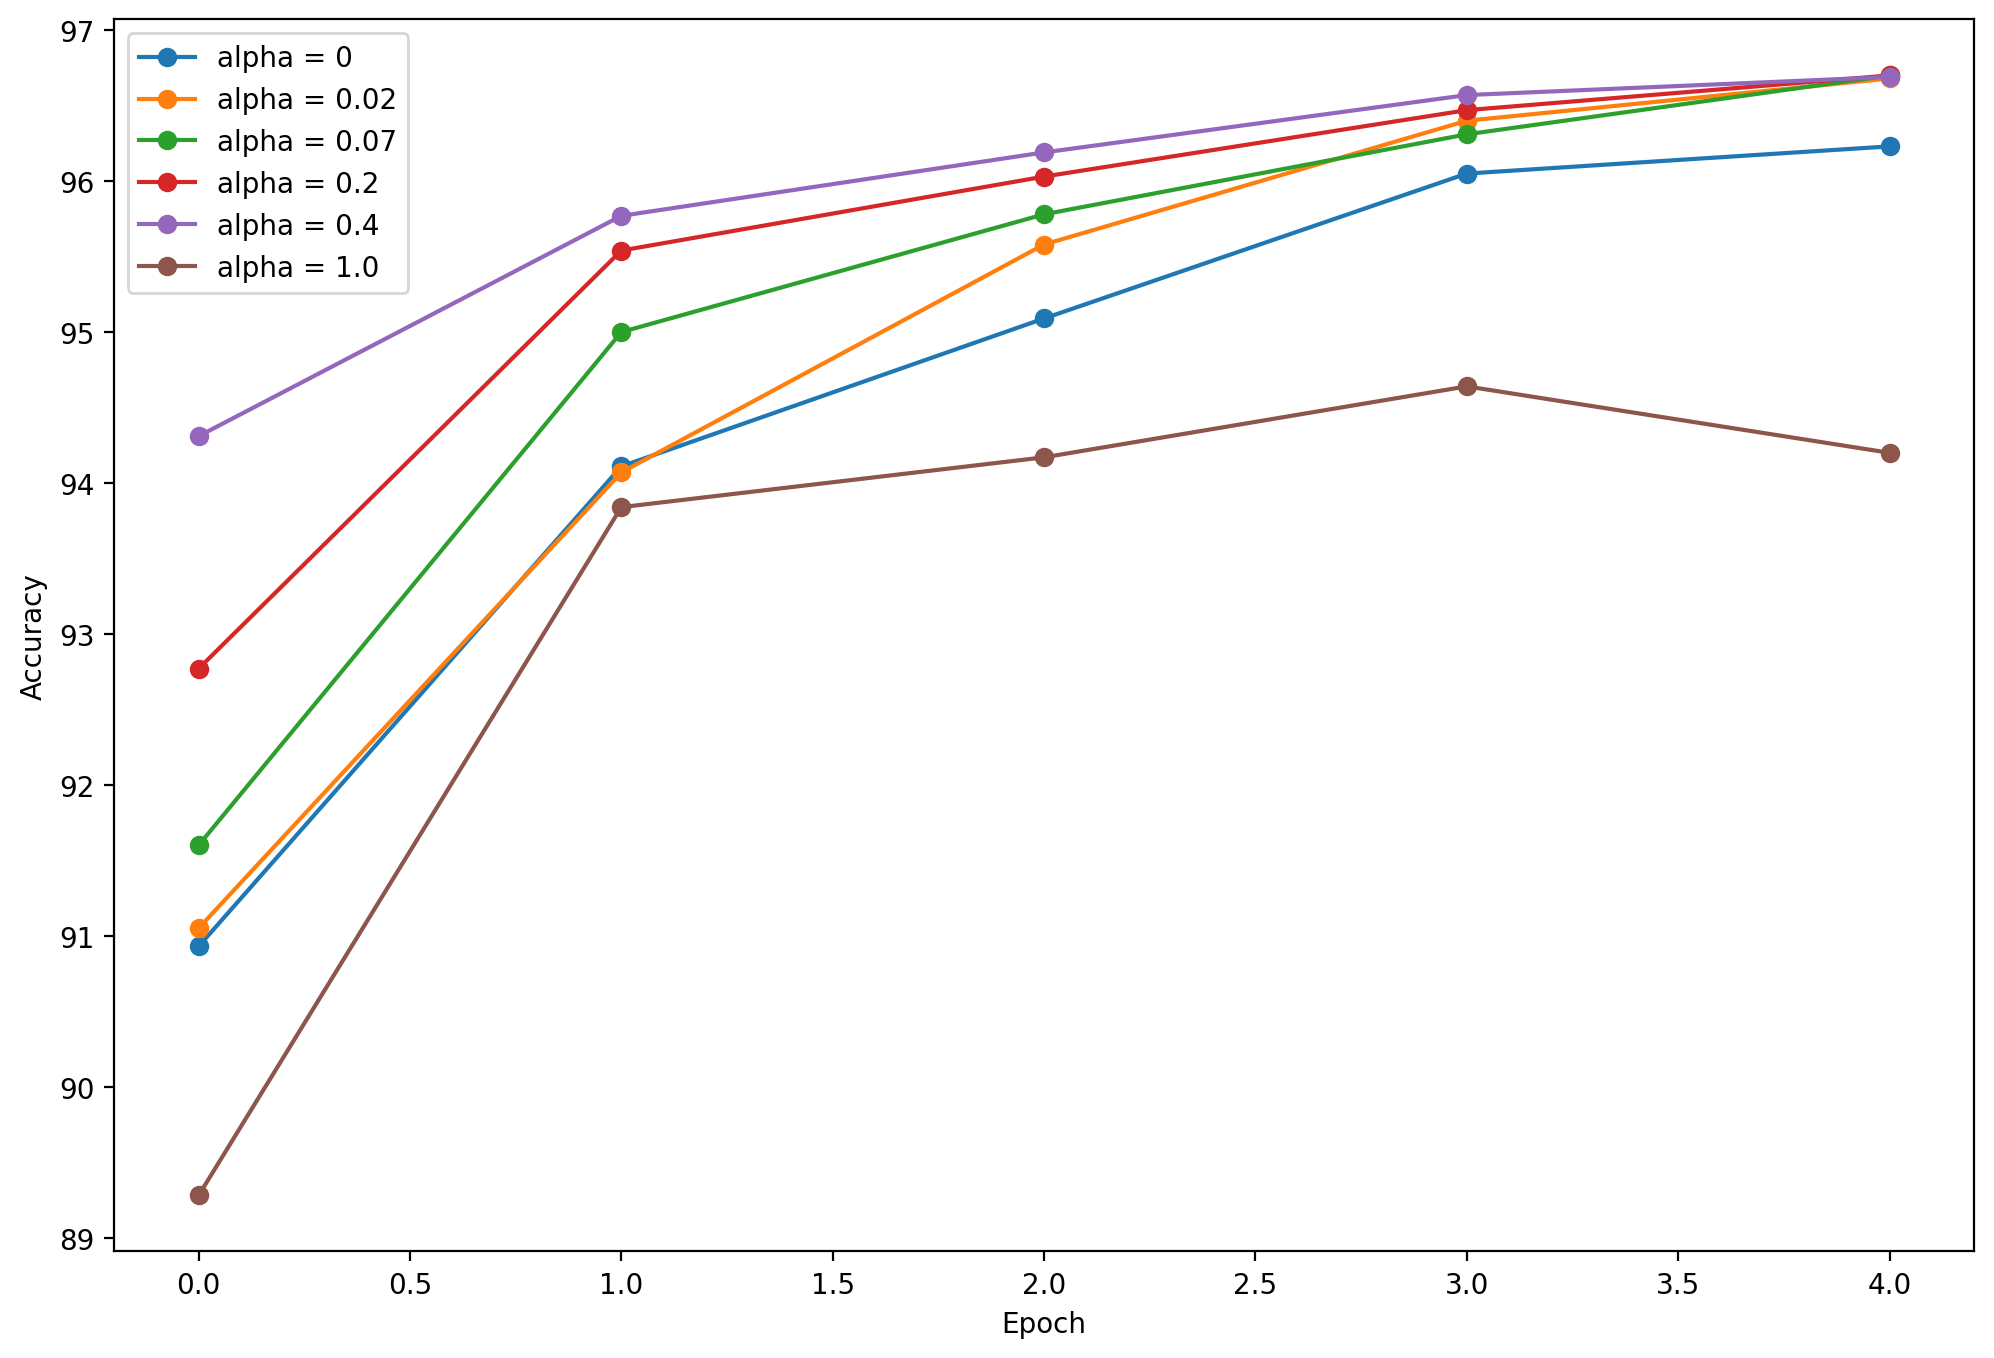

In [82]:
plt.figure(figsize=(12, 8))

for alpha, acc_list in exp_dict.items():
    plt.plot(acc_list, label=f"alpha = {alpha}", marker="o")

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Train Student with Attention loss


$$\mathcal{L}=(1-\alpha) \mathcal{L}_{c e}\left(z_{s}, y\right)+\alpha \mathcal{L}_{A T}\left(h_{s}, h_{t}\right)$$

$$\mathcal{L}_{A T}=\mathcal{L}\left(\mathbf{W}_{S}, x\right)+\frac{\beta}{2} \sum_{j \in \mathcal{I}}\left\|\frac{Q_{S}^{j}}{\left\|Q_{S}^{j}\right\|_{2}}-\frac{Q_{T}^{j}}{\left\|Q_{T}^{j}\right\|_{2}}\right\|_{p}$$


<div>
<img src="resources/at_arch.png" width=80%/>
</div>


In [59]:
class AT(nn.Module):
    """
    Paying More Attention to Attention: Improving the Performance of Convolutional
    Neural Networks wia Attention Transfer
    https://arxiv.org/pdf/1612.03928.pdf
    """

    def __init__(self, p=2):
        super(AT, self).__init__()
        self.p = p

    def forward(self, fm_s, fm_t):
        loss = torch.norm(self.attention_map(fm_s) - self.attention_map(fm_t), self.p)

        return loss

    def attention_map(self, fm):
        am = torch.pow(torch.abs(fm), self.p).sum(1, keepdim=True)
        am = F.normalize(am, dim=(2, 3))
        return am

In [60]:
def train_at(
    teacher,
    student,
    epoch,
    optimizer,
    at_loss,
    forward_hook_manager_teacher,
    forward_hook_manager_student,
    alpha=0.1,
    args=args,
):
    device = "cuda" if args["cuda"] else "cpu"
    teacher.to(device)
    teacher.eval()
    student.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        if args["cuda"]:
            data, target = data.to(device), target.to(device)
        # This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = student(data)

        with torch.no_grad():
            output_t = teacher(data)

        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss_label = F.cross_entropy(output, target)

        # Calculate Attention loss
        teacher_io_dict = forward_hook_manager_teacher.pop_io_dict()
        student_io_dict = forward_hook_manager_student.pop_io_dict()
        loss_at = at_loss(student_io_dict["conv1"]["output"], teacher_io_dict["conv1"]["output"]) + at_loss(
            student_io_dict["conv2"]["output"], teacher_io_dict["conv2"]["output"]
        )

        loss = (1 - alpha) * loss_label + alpha * loss_at
        # dloss/dx for every Variable
        loss.backward()
        # to do a one-step update on our parameter.
        optimizer.step()
        # Print out the loss periodically.
        if batch_idx % args["log_interval"] == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

In [61]:
alphas = [0, 0.05, 0.07, 0.1, 0.2, 0.4, 0.5, 1.0]

exp_dict = {}

for alpha in alphas:
    print(f"__________(alpha = {alpha})__________")
    acc_list = []
    forward_hook_manager_teacher = ForwardHookManager(device)
    forward_hook_manager_student = ForwardHookManager(device)

    student_at = StudentNetClass()
    student_at.to(device)

    # Create forward hooks for outputs of conv1 and conv2 for teacher and student

    forward_hook_manager_teacher.add_hook(teacher, "conv1", requires_input=False, requires_output=True)
    forward_hook_manager_student.add_hook(student_at, "conv1", requires_input=False, requires_output=True)

    forward_hook_manager_teacher.add_hook(teacher, "conv2", requires_input=False, requires_output=True)
    forward_hook_manager_student.add_hook(student_at, "conv2", requires_input=False, requires_output=True)

    p = 2
    at_loss = AT(p)

    optimizer = optim.SGD(student_at.parameters(), lr=args["lr"], momentum=args["momentum"])

    for epoch in range(args["epochs"]):
        train_at(
            teacher,
            student_at,
            epoch,
            optimizer,
            at_loss,
            forward_hook_manager_teacher,
            forward_hook_manager_student,
            alpha,
        )
        acc_list.append(test(student_at))

    exp_dict[alpha] = acc_list

__________(alpha = 0)__________
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.315188

Test set: Average loss: 0.0005, Accuracy: 8329/10000 (83%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.851266

Test set: Average loss: 0.0003, Accuracy: 9150/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.570436

Test set: Average loss: 0.0002, Accuracy: 9385/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.476874

Test set: Average loss: 0.0002, Accuracy: 9477/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.424622

Test set: Average loss: 0.0001, Accuracy: 9551/10000 (96%)

__________(alpha = 0.05)__________
Train Epoch: 0 [0/60000 (0%)]	Loss: 3.402519

Test set: Average loss: 0.0003, Accuracy: 9203/10000 (92%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.691256

Test set: Average loss: 0.0002, Accuracy: 9430/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.481427

Test set: Average loss: 0.0001, Accuracy: 9564/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.411229

Test set: Average loss: 0.0001, Accurac

In [62]:
# do not forget to close the door
forward_hook_manager_teacher.clear()
forward_hook_manager_student.clear()

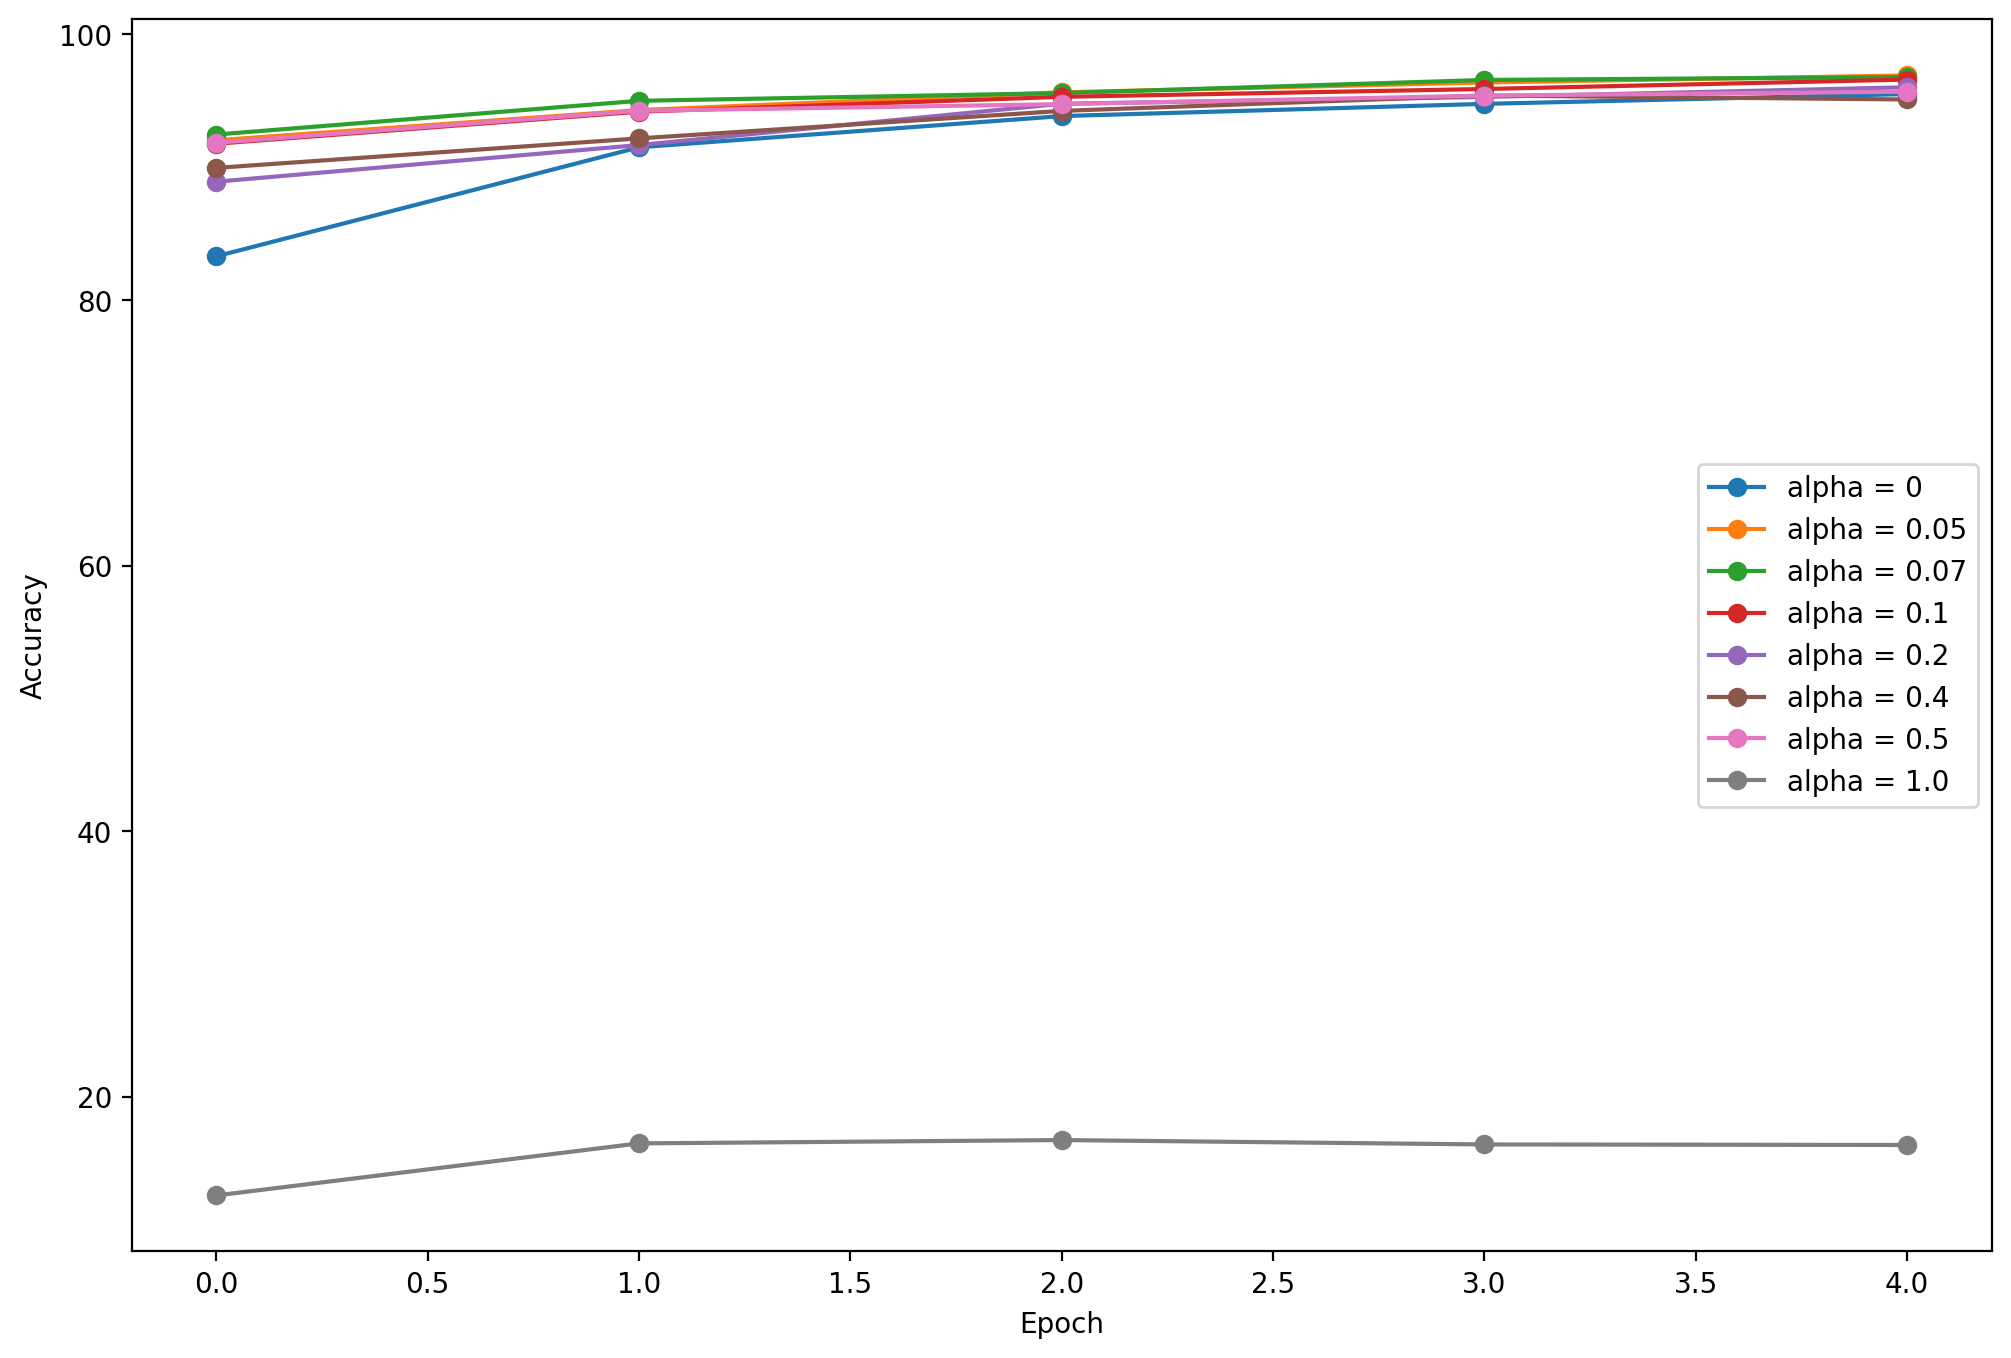

In [63]:
plt.figure(figsize=(12, 8))

for alpha, acc_list in exp_dict.items():
    plt.plot(acc_list, label=f"alpha = {alpha}", marker="o")

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

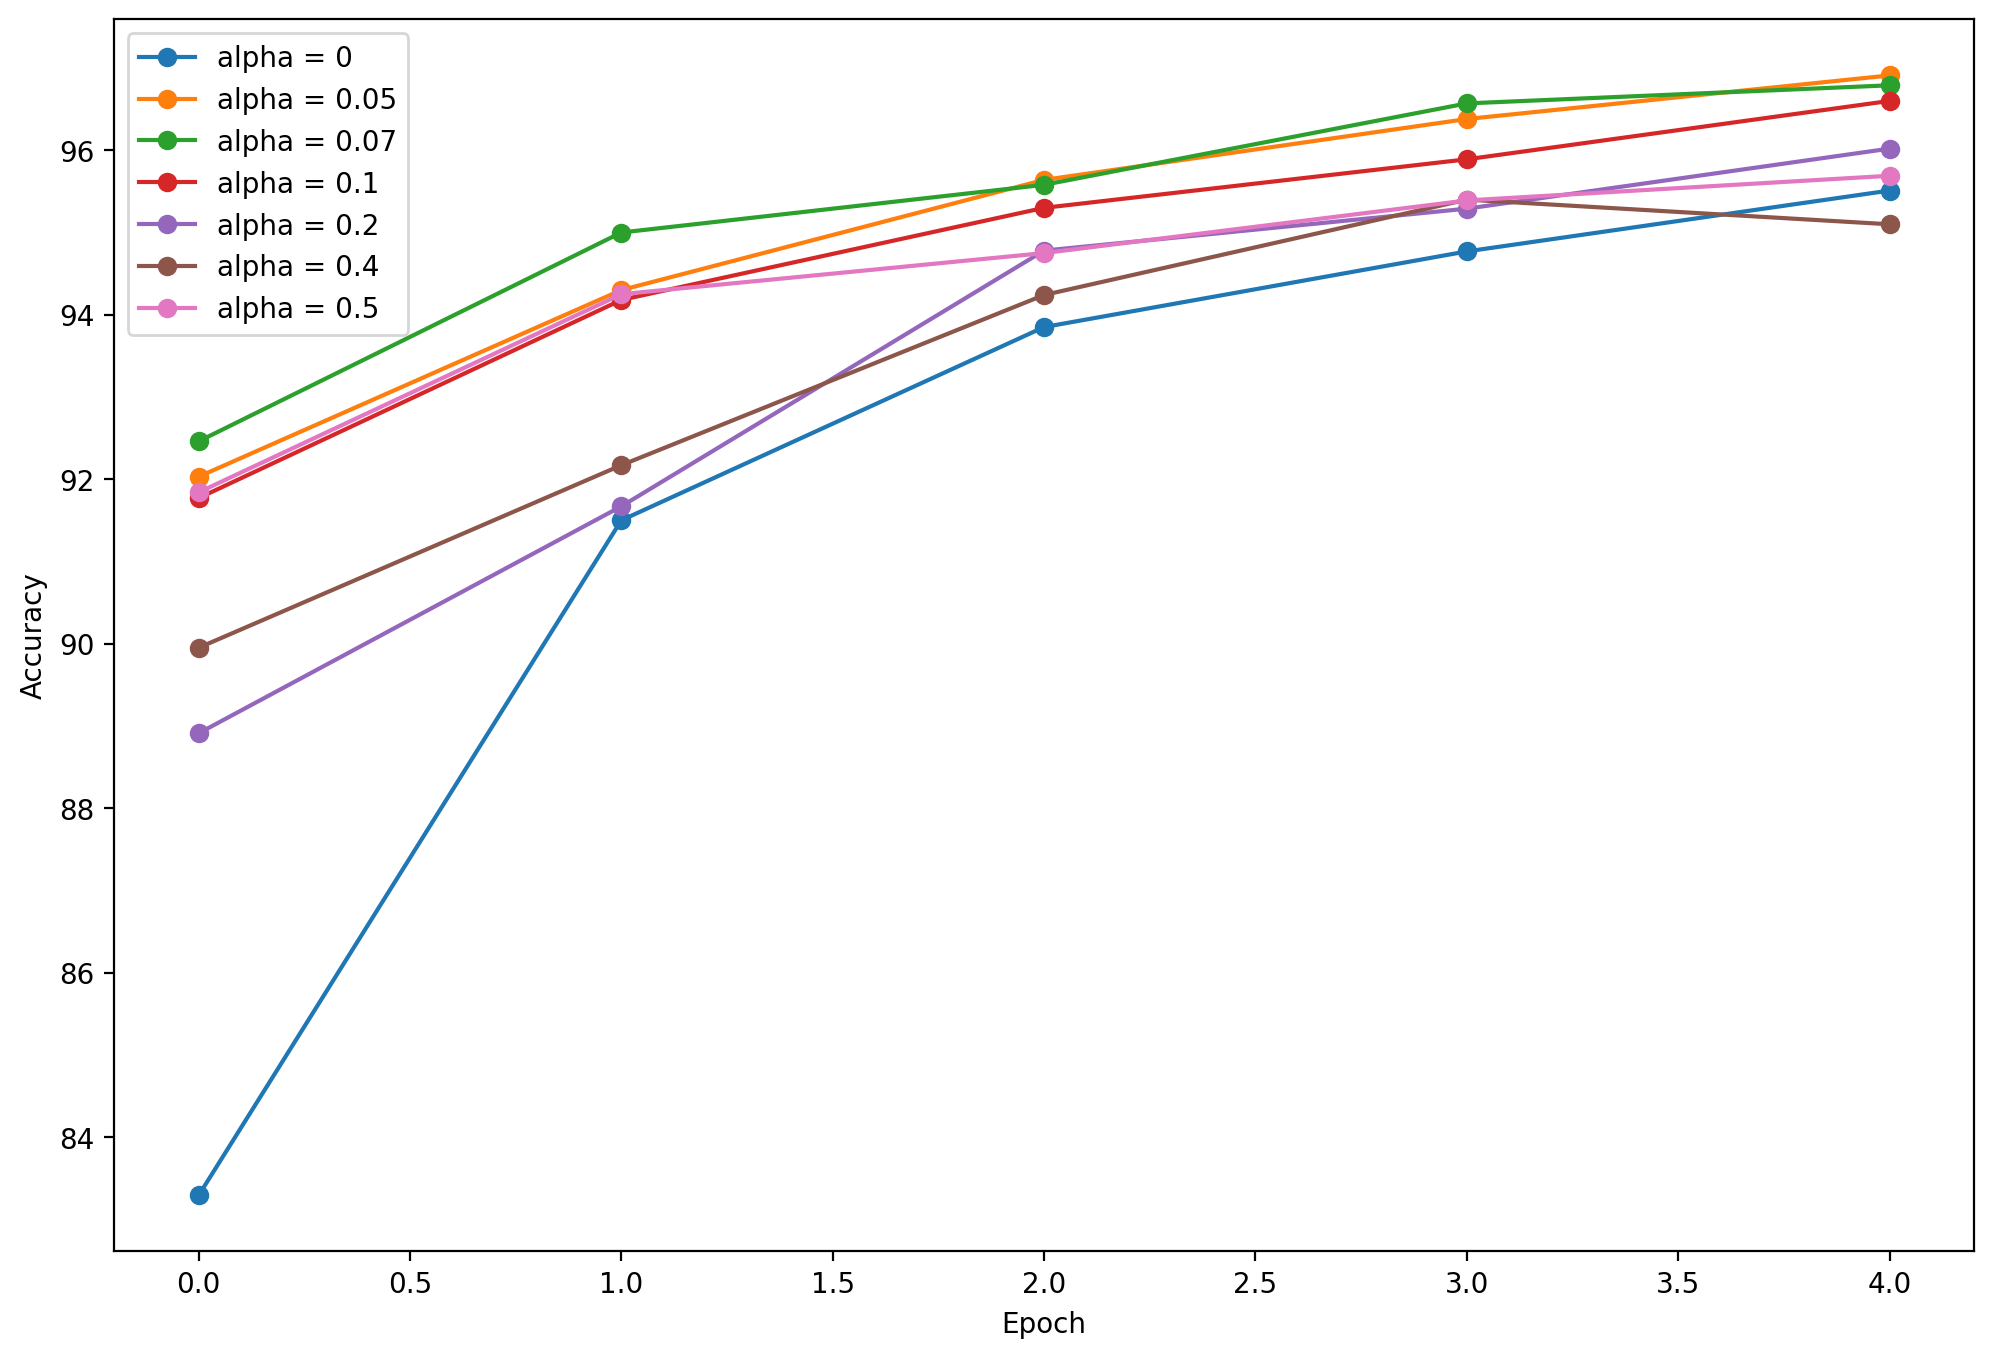

In [65]:
plt.figure(figsize=(12, 8))

for alpha, acc_list in list(exp_dict.items()):
    if alpha != 1.0:
        plt.plot(acc_list, label=f"alpha = {alpha}", marker="o")

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

## 3. Pruning: Lottery Ticket Hypothesis
<div>
<img src="resources/pruning.png" width=70%/>
</div>



[The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks](https://arxiv.org/abs/1803.03635): Unstructured, During-Training, Iterative, Magnitude

<div>
<img src="resources/lottery.png" width=70%/>
</div>

<div>
<img src="resources/lottery_example.png" width=40%/>
</div>

## 4. Quantization: GPT-Q


По порядку квантизуем слои. Для текущего слоя $W$ и входа $X$ ищем малобитный $\hat{W}$: $\hat{W} = \arg \min_{\hat{W}} \|WX - \hat{W}X \|_2^2$

Optimal Brain Quantization:
Будем использовать метод Ньютона с гессианом $H_F=X_F X_F^\top$

<div>
<img src="resources/obq.png" width=70%/>
</div>
$O(d_{row} \cdot d_{col}^3)$ - слишком медленно!


<div>
<img src="resources/gptq.png" width=70%/>
</div>
<div>
<img src="resources/gptq_algo.png" width=70%/>
</div>
Уже $O(\max{d_{row} \cdot d_{col}^2,  d_{col}^3})$

Работает с трансформерами [из коробки](https://github.com/PanQiWei/AutoGPTQ)